## Belardinelli analysis
* timing of start of fixation (task vs familiarity)

* location of fixation (task x familiarity x timing(1st, 2nd, 3rd))

* 

In [1]:
import statsmodels as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from patsy.contrasts import ContrastMatrix
import scipy.stats as spstat
import patsy
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sm.__version__

In [3]:
def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]
class EffectCoding(object):   
    
    def _effect_Coding(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * np.ones((nlevels, nlevels-1))
        contr[:-1][np.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = np.column_stack((np.ones(len(levels)),
                                   self._effect_Coding(levels)))
        return ContrastMatrix(contrast, _name_levels("ec.", levels))

    def code_without_intercept(self, levels):
        contrast = self._effect_Coding(levels)
        return ContrastMatrix(contrast, _name_levels("ec.", levels[:-1]))

In [2]:
PROCESSED_DATA_PATH = '../ProcessedData/'
PLOT_PATH = '../PLOTS/LMM/'

In [4]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/02_ET_samples_fixations.csv')
# samples_df.timestamp_dt = pd.to_datetime(samples_df.timestamp_dt)
samples_df['timestamp_dt'] = pd.to_datetime(samples_df['timeStamp'])
samples_df.set_index('timestamp_dt', inplace=True)
#samples_df.set_index('timeStamp', inplace=True)
samples_df.head()

,timeStamp,tobiiTimeStamp,isLeftBlinkingW,isRightBlinkingW,isLeftBlinkingL,isRightBlinkingL,hitObjectName,triggerPressed,hmdPos_x,hmdPos_y,...,eye_vel_h,eye_vel_v,head_vel_h,head_vel_v,eye_angular_vel,head_angular_vel,isFix,fix_duration,isOutlierFix,isOutlierSac
timestamp_dt,,,,,,,,,,,,,,,,,,,,,
2020-03-03 14:10:21.934372425,2020-03-03 14:10:21.934372425,92.661469,False,False,False,False,Floor,True,59.806953,111.138611,...,0.578143,0.129368,-0.101947,0.048004,0.592440,0.112683,True,0.164211,False,NaN
2020-03-03 14:10:21.954322577,2020-03-03 14:10:21.954322577,92.679977,False,False,False,False,Floor,True,59.811569,111.140045,...,0.455382,0.126974,-0.123568,0.104051,0.472752,0.161541,True,0.164211,False,NaN
2020-03-03 14:10:21.965354443,2020-03-03 14:10:21.965354443,92.691093,False,False,False,False,Floor,True,59.814671,111.141747,...,-0.061125,-0.042702,-0.138762,0.165018,0.074563,0.215606,True,0.164211,False,NaN
2020-03-03 14:10:21.987304688,2020-03-03 14:10:21.987304688,92.713226,False,False,False,False,Floor,True,59.817936,111.147697,...,-0.422613,-0.060997,-0.148173,0.205017,0.426993,0.252957,True,0.164211,False,NaN
2020-03-03 14:10:21.998291016,2020-03-03 14:10:21.998291016,92.724388,False,False,False,False,Floor,True,59.818928,111.151527,...,-0.096335,0.059626,-0.163896,0.256468,0.113294,0.304364,True,0.164211,False,NaN


In [5]:
tmpdf = samples_df.query('isFix == 1 and isOutlierFix==0 and fix_duration!=0 and hitToolPart!="Cue"')

tmpdf = tmpdf.drop_duplicates(subset=['subjectID', 'trialID', 'isFix', 'fix_duration'], keep='first')

# display(tmpdf)

tmpdf = tmpdf.groupby(['subjectID','trialID','cue','orientation',
                       'Familiarity','hitToolPart'])['isFix'].count()
tmpdf = tmpdf.groupby(level=[0,1]).apply(lambda x: x/float(x.sum()))
tmpdf = tmpdf.reset_index()
tmpdf = tmpdf.query('hitToolPart == "Effector"')
tmpdf['isFixLogOdds'] = np.log(tmpdf.isFix/(1 - tmpdf.isFix))
tmpdf['isFixOdds'] = tmpdf.isFix/(1 - tmpdf.isFix)
# tmpdf['isFixA'] = tmpdf.isFix
tmpdf.replace([np.inf, -np.inf], np.nan, inplace=True)
tmpdf.dropna(inplace=True)
display(tmpdf)

,subjectID,trialID,cue,orientation,Familiarity,hitToolPart,isFix,isFixLogOdds,isFixOdds
0,2,0,use,left,familiar,Effector,0.880000,1.992430,7.333333
2,2,1,lift,left,unfamiliar,Effector,0.250000,-1.098612,0.333333
4,2,2,lift,left,familiar,Effector,0.333333,-0.693147,0.500000
6,2,3,use,right,unfamiliar,Effector,0.789474,1.321756,3.750000
10,2,6,use,left,unfamiliar,Effector,0.900000,2.197225,9.000000
...,...,...,...,...,...,...,...,...,...
1957,8,139,use,right,familiar,Effector,0.318182,-0.762140,0.466667
1959,8,140,use,left,familiar,Effector,0.607143,0.435318,1.545455
1961,8,141,use,right,unfamiliar,Effector,0.318182,-0.762140,0.466667
1963,8,142,use,right,unfamiliar,Effector,0.526316,0.105361,1.111111


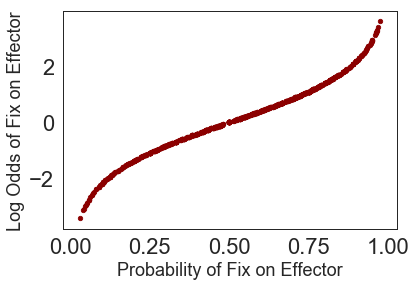

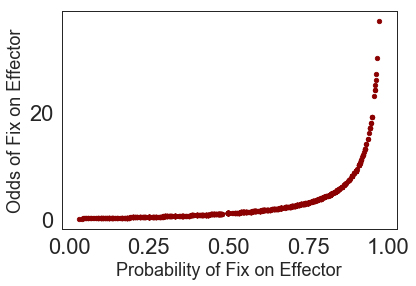

In [23]:
sns.set(style="white", palette="dark",font_scale=2.5, context = 'paper')

tmpdf.plot(kind='scatter', x='isFix', y='isFixLogOdds',color='darkred')
plt.ylabel('Log Odds of Fix on Effector',fontsize=18)
plt.xlabel('Probability of Fix on Effector',fontsize=18)
plt.savefig(f'{PLOT_PATH}ScatterplotLogOdds.png',
            transparent=True, bbox_inches='tight', quality=90)

tmpdf.plot(kind='scatter', x='isFix', y='isFixOdds',color='darkred')
plt.ylabel('Odds of Fix on Effector',fontsize=18)
plt.xlabel('Probability of Fix on Effector',fontsize=18)
plt.savefig(f'{PLOT_PATH}ScatterplotOdds.png',
            transparent=True, bbox_inches='tight', quality=90)

In [12]:
tmpdf['isFixLag'] = (tmpdf
                     .groupby(['subjectID'])
                     ['isFixLogOdds']
                     .transform(lambda x: x.shift())
                    )


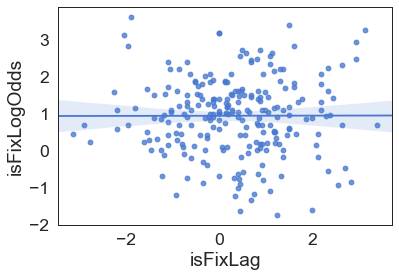

In [114]:
# tmpdf.plot.scatter(x='isFix', y='isFixLag')

sns.regplot(y='isFixLogOdds', x='isFixLag', data=tmpdf.query('Familiarity=="unfamiliar" and cue=="use"'))

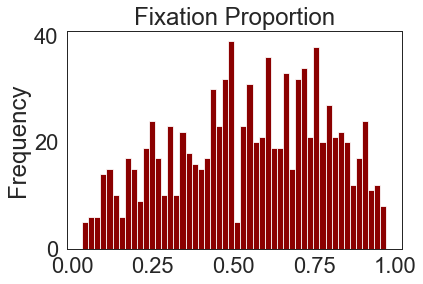

In [22]:
tmpdf.isFix.plot(kind='hist', bins=50,color='darkred')
plt.title('Fixation Proportion')
plt.savefig(f'{PLOT_PATH}HistIsFIx.png',
            transparent=True, bbox_inches='tight', quality=90)

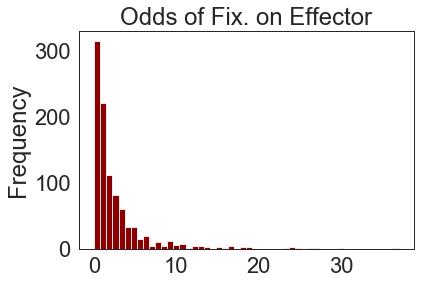

In [21]:
tmpdf.isFixOdds.plot(kind='hist', bins=50,color='darkred')
plt.title('Odds of Fix. on Effector')
plt.savefig(f'{PLOT_PATH}HistFixOdds.png',
            transparent=True, bbox_inches='tight', quality=90)

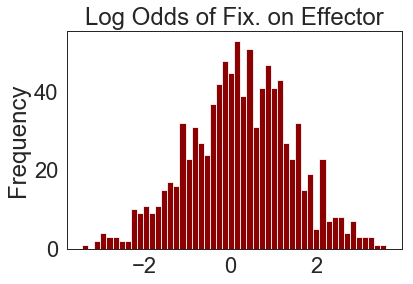

In [19]:
tmpdf.isFixLogOdds.plot(kind='hist', bins=50,color='darkred')
plt.title('Log Odds of Fix. on Effector')
plt.savefig(f'{PLOT_PATH}HistLogOdds.png',
            transparent=True, bbox_inches='tight', quality=90)

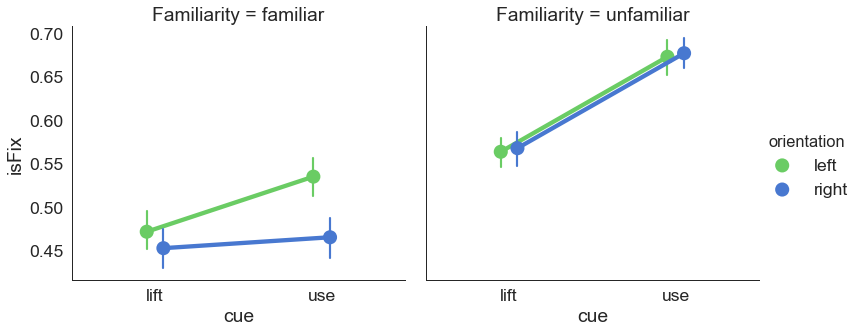

In [75]:
# tmpdf = samples_df.query('isFix == 1 and isOutlierFix==0 and fix_duration!=0 and hitToolPart!="Cue"')
# tmpdf = tmpdf.drop_duplicates(subset=['subjectID', 'trialID', 'isFix', 'fix_duration'], keep='first')
# tmpdf = tmpdf.groupby(['trialID','cue','hitToolPart'],as_index=False)['isFix'].mean()
# display(tmpdf)
# sns.set(context = "poster", style="white", palette="dark", font_scale=2.5, rc={'figure.figsize':(12,9)})
sns.set(style="white", palette="muted",font_scale=2, context = 'paper')
g = (sns.catplot(data = tmpdf,
                 legend = True, x = 'cue',
                 y = 'isFix', kind = 'point',ci=68,
                 scale=2,dodge=0.1, 
                 hue='orientation', order=['lift', 'use'],
                 col = 'Familiarity', palette=['g', 'b'], height=5, aspect=1.1, sharey=True,)
)
# g.set(ylabel='log odds fixations on Effector')


In [21]:
endog, exog = patsy.dmatrices('''isFixLogOdds ~ 1 +
                              C(cue,EffectCoding) * 
                              C(Familiarity,EffectCoding) * 
                              C(orientation,EffectCoding)
                              ''',
                             tmpdf)
# groups = patsy.dmatrix('subjectID', tmpdf)
# formula = '''isFix ~ 1 + C(cue, EffectCoding) * 
#             C(Familiarity, EffectCoding) * 
#             C(orientation, EffectCoding) * 
#             C(hitToolPart, EffectCoding)'''
# re_exog = patsy.dmatrix(re_formula, data = tmpdf)
model = sm.regression.mixed_linear_model.MixedLM(endog, exog, groups=tmpdf['subjectID'] )
result = model.fit()
display(result.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                         Mixed Linear Model Regression Results
========================================================================================================================================================
Model:                                            MixedLM                                Dependent Variable:                                isFixLogOdds
No. Observations:                                 959                                    Method:                                            REML        
No. Groups:                                       7                                      Scale:                                             1.2433      
Min. group size:                                  114                                    Log-Likelihood:                                    -1476.0884  
Max. group size:                                  144                                    Converged:                                         Yes         
Mean group size:                                  137.0                                                                                                 
--------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                      0.226    0.070  3.222 0.001  0.088  0.363
C(cue, EffectCoding)[ec.lift]                                                                                 -0.522    0.072 -7.237 0.000 -0.663 -0.380
C(Familiarity, EffectCoding)[ec.familiar]                                                                     -0.662    0.072 -9.188 0.000 -0.803 -0.521
C(orientation, EffectCoding)[ec.left]                                                                          0.087    0.072  1.211 0.226 -0.054  0.228
C(cue, EffectCoding)[ec.lift]:C(Familiarity, EffectCoding)[ec.familiar]                                        0.512    0.144  3.551 0.000  0.229  0.794
C(cue, EffectCoding)[ec.lift]:C(orientation, EffectCoding)[ec.left]                                           -0.102    0.144 -0.710 0.478 -0.385  0.180
C(Familiarity, EffectCoding)[ec.familiar]:C(orientation, EffectCoding)[ec.left]                                0.116    0.144  0.802 0.422 -0.167  0.398
C(cue, EffectCoding)[ec.lift]:C(Familiarity, EffectCoding)[ec.familiar]:C(orientation, EffectCoding)[ec.left] -0.061    0.288 -0.212 0.832 -0.626  0.504
Group Var                                                                                                      0.025    0.018                           
========================================================================================================================================================

"""

In [22]:
result.bootstrap(nrep=100, method='nm', disp=0, store=1)

<class 'statsmodels.regression.mixed_linear_model.MixedLM'>


AttributeError: 'MixedLMResults' object has no attribute 'exog'

In [23]:
# exog.design_info.term_codings
patsy.dmatrix('''C(Familiarity, EffectCoding)''',
                             tmpdf)

DesignMatrix with shape (959, 2)
  Intercept  C(Familiarity, EffectCoding)[ec.familiar]
          1                                        0.5
          1                                       -0.5
          1                                        0.5
          1                                       -0.5
          1                                       -0.5
          1                                       -0.5
          1                                       -0.5
          1                                       -0.5
          1                                        0.5
          1                                       -0.5
          1                                       -0.5
          1                                        0.5
          1                                        0.5
          1                                        0.5
          1                                       -0.5
          1                                        0.5
          1                     

In [24]:
tmpdf = samples_df.query('isFix == 1 and isOutlierFix==0 and fix_duration!=0 and hitToolPart!="Cue"')

tmpdf = tmpdf.drop_duplicates(subset=['subjectID', 'trialID', 'isFix', 'fix_duration'], keep='first')

# display(tmpdf)

tmpdf = tmpdf.groupby(['subjectID','trialID','cue','orientation',
                       'Familiarity','hitToolPart'],as_index=False)['fix_duration'].mean()
display(tmpdf)

,subjectID,trialID,cue,orientation,Familiarity,hitToolPart,fix_duration
0,2,0,use,left,familiar,Effector,0.081809
1,2,0,use,left,familiar,Handle,0.114704
2,2,1,lift,left,unfamiliar,Effector,0.012029
3,2,1,lift,left,unfamiliar,Handle,0.272527
4,2,2,lift,left,familiar,Effector,0.111767
...,...,...,...,...,...,...,...
1962,8,141,use,right,unfamiliar,Handle,0.137148
1963,8,142,use,right,unfamiliar,Effector,0.095707
1964,8,142,use,right,unfamiliar,Handle,0.165514
1965,8,143,lift,right,familiar,Effector,0.082022


In [25]:
endog, exog = patsy.dmatrices('''fix_duration ~ 1 + 
                              C(cue, EffectCoding) * 
                              C(Familiarity, EffectCoding) * 
                              C(orientation, EffectCoding) *
                              C(hitToolPart, EffectCoding)''',
                             tmpdf)


groups = patsy.dmatrix('subjectID', tmpdf)
# re_exog = patsy.dmatrix(re_formula, data = tmpdf)
model = sm.regression.mixed_linear_model.MixedLM(endog, exog, groups=tmpdf['subjectID'], ).fit()
display(model.summary())

d:\studium\bachelorarbeit\gaze_tool_interaction\gti\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                              Mixed Linear Model Regression Results
==================================================================================================================================================================================================
Model:                                                          MixedLM                                              Dependent Variable:                                              fix_duration
No. Observations:                                               1967                                                 Method:                                                          REML        
No. Groups:                                                     7                                                    Scale:                                                           0.0065      
Min. group size:                                                258                                                  Log-Likelihood:                                                  2102.1144   
Max. group size:                                                288                                                  Converged:                                                       Yes         
Mean group size:                                                281.0                                                                                                                             
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                                0.138    0.008 17.077 0.000  0.122  0.154
C(cue, EffectCoding)[ec.lift]                                                                                                                           -0.012    0.004 -3.393 0.001 -0.019 -0.005
C(Familiarity, EffectCoding)[ec.familiar]                                                                                                                0.004    0.004  1.239 0.215 -0.003  0.012
C(orientation, EffectCoding)[ec.left]                                                                                                                   -0.000    0.004 -0.025 0.980 -0.007  0.007
C(hitToolPart, EffectCoding)[ec.Effector]                                                                                                               -0.015    0.004 -4.273 0.000 -0.023 -0.008
C(cue, EffectCoding)[ec.lift]:C(Familiarity, EffectCoding)[ec.familiar]                                                                                 -0.002    0.007 -0.228 0.819 -0.016  0.013
C(cue, EffectCoding)[ec.lift]:C(orientation, EffectCoding)[ec.left]                                                                                     -0.000    0.007 -0.069 0.945 -0.015  0.014
C(Familiarity, EffectCoding)[ec.familiar]:C(orientation, EffectCoding)[ec.left]                                                                          0.012    0.007  1.708 0.088 -0.002  0.027
C(cue, EffectCoding)[ec.lift]:C(hitToolPart, EffectCoding)[ec.Effector]                                                                                 -0.003    0.007 -0.458 0.647 -0.018  0.011
C(Familiarity, EffectCoding)[ec.familiar]:C(hitToolPart, EffectCoding)[ec.Effector]                                               